## Deep learning approach

In [1]:
#Deep learning library of choice PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching

import numpy as np
import scipy.stats as stats
import pandas as pd

# Time to check that the gpu optimization is actually helping

import time 

# Some graphing

import matplotlib.pyplot as plt

In [2]:
# use GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Count the number of CPU cores available, this returns the number of threads, because most cpus have a thread count equal to twice their core count I have halved the count when multithreading
# Set this number to one if you dont want to multi thread the process

cpuCount = os.cpu_count()
print(cpuCount)

cuda:0
24


In [3]:
#This value will allow you to change how many periods back the data will consider. for example if you select 1 it will only look at the previous period, Maximum value is currently set to 8.
#if you want to try over more data periods a greater number of datalet length will need to be prepped in the data prep folders. By default a maximum of 8

dataperiods = 8

df = pd.read_csv('../datalets/datalet{}.csv'.format(dataperiods+1),index_col=False)


In [4]:
display(df)

,period0,period1,period2,period3,period4,period5,period6,period7,period8
0,3.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0
1,1.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
2,3.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,3.0
3,0.0,1.0,0.0,0.0,1.0,1.0,1.0,3.0,3.0
4,1.0,0.0,0.0,1.0,1.0,1.0,3.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...
9986,0.0,0.0,2.0,0.0,0.0,1.0,0.0,3.0,1.0
9987,0.0,2.0,0.0,0.0,1.0,0.0,3.0,1.0,3.0
9988,2.0,0.0,0.0,1.0,0.0,3.0,1.0,3.0,3.0
9989,0.0,0.0,1.0,0.0,3.0,1.0,3.0,3.0,0.0


In [5]:
dataheaders = []

for i in range(df.shape[1]-1):
	dataheaders.append('period{}'.format(i))
 


data = torch.Tensor(df[dataheaders].values).type(torch.float)
labels = torch.Tensor(df['period{}'.format(df.shape[1]-1)].values).type(torch.LongTensor)

In [6]:
print(data)
print(labels)

tensor([[3., 1., 3.,  ..., 0., 0., 1.],
        [1., 3., 0.,  ..., 0., 1., 1.],
        [3., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [2., 0., 0.,  ..., 3., 1., 3.],
        [0., 0., 1.,  ..., 1., 3., 3.],
        [0., 1., 0.,  ..., 3., 3., 0.]])
tensor([1, 1, 3,  ..., 3, 0, 0])


In [7]:
# First we are going to split the data into three parts, evaluation, test and training data. I do this with two instances of train_test_split, just for the sake of convinience.

traintemp_data,eval_data, traintemp_labels,eval_labels = train_test_split(data, labels, test_size=.01)

train_data,test_data, train_labels,test_labels = train_test_split(traintemp_data, traintemp_labels, test_size=.01)

#then we are going to pass the data to the Pytorch data loader, this is going to allow us to split it into mini batches that will be run through the model.

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

train_data = train_data
test_data = test_data

#Best to keep batches to powers of two for speed reasons adjust as needed for your own memory constraints 
x = 6
batches   = 2**x
train_loader = DataLoader(train_data,batch_size=batches,shuffle=True,drop_last=True, num_workers=int(cpuCount/2))
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) 

In [8]:
# create a class for the model

class ANN(nn.Module):
	def __init__(self, Input_dim, Output_dim):
		super().__init__()

		### input layer
		self.input = nn.Linear(Input_dim,4)
		
		### hidden layers
		self.hidden1    = nn.Linear(4,4)
		self.bnorm1 = nn.BatchNorm1d(4) 
		self.hidden2    = nn.Linear(4,4)
		self.bnorm2 = nn.BatchNorm1d(4) 
		self.hidden3    = nn.Linear(4,4)
		self.bnorm3 = nn.BatchNorm1d(4)
		self.hidden4    = nn.Linear(4,4)

		### output layer
		self.output = nn.Linear(4,Output_dim)
	
	# forward pass
	def forward(self,x):

		# input (x starts off normalized)
		x = F.relu( self.input(x) )


		# hidden layer 1
		x = self.bnorm1(x) # batchnorm
		x = F.relu( self.hidden1(x) )      # linear function and activation function

		# hidden layer 2
		x = self.bnorm2(x) # batchnorm
		x = F.relu( self.hidden2(x) )      # linear function and activation function
		
		# hidden layer 3
		x = self.bnorm3(x)
		x = F.relu( self.hidden3(x) )      # linear function and activation function
  
		# hidden layer 4

		x = F.relu( self.hidden4(x) )

		# output layer
		return self.output(x)

In [9]:
def trainthemodel(learning):
	
	# Loss function and optimizer, I chose cross entropy loss as it is best for classification problems. 
	lossfun = nn.CrossEntropyLoss()
	optimizer = torch.optim.SGD(model.parameters(),lr=learning)
	
	#initialize losses
	losses = torch.zeros(numofepochs)
	trainAcc = []
	testAcc = []

	model.to(device)
	
	#now lets actually loop over the training epochs to train the model
	for epoch in range(numofepochs):
		
		# switch on training mode
		model.train()

		# loop over training data batches
		batchAcc  = []
		batchLoss = []
		for X,y in train_loader:

			X = X.to(device)
			y = y.to(device)
			
			# forward pass and loss
			yHat = model(X)
			loss = lossfun(yHat,y)

			# backprop
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			# loss from this batch
			batchLoss.append(loss.item())

			yHat = yHat.cpu()
			y = y.cpu()

			# compute training accuracy for this batch
			batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
			
		# now that we've trained through the batches, get their average training accuracy
		trainAcc.append( np.mean(batchAcc)) 

		# and get average losses across the batches
		losses[epoch] = np.mean(batchLoss)
		
		### test accuracy

		# Lets turn eval back on so we dont overfit with the test data 
		model.eval()
		X,y = next(iter(test_loader)) # extract X,y from test dataloader

		X = X.to(device)
		y = y.to(device)  

		with torch.no_grad(): # deactivates autograd
			yHat = model(X)
   
		yHat = yHat.cpu()
		y = y.cpu()   

		testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()) )

		print('epoch {} done at time {} '.format(epoch,time.perf_counter()))


	# function output
	return trainAcc,testAcc,losses,model

In [10]:
input_dim = df.shape[1]-1
output_dim = 4
numofepochs = 4
learningrate = 0.01

model = ANN(Input_dim = input_dim,Output_dim = output_dim)
trainAcc,testAcc,losses,model = trainthemodel(learningrate)

epoch 0 done at time 462.3309251 
epoch 1 done at time 468.1758247 
epoch 2 done at time 470.7604777 
epoch 3 done at time 477.0068483 


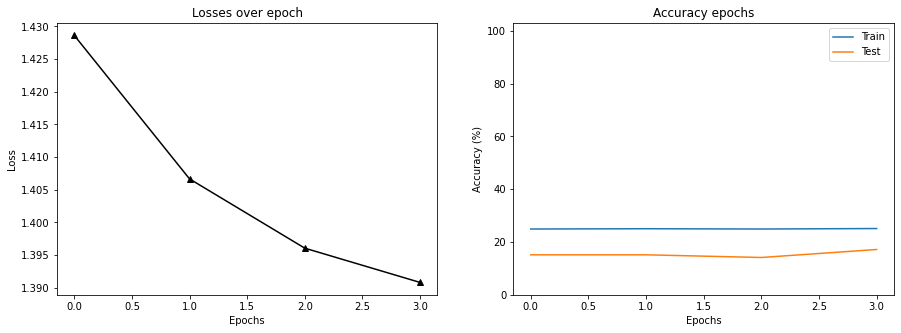

In [11]:
fig,ax = plt.subplots(1,2,figsize=(15,5))



ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses over epoch')

ax[1].plot(trainAcc,)
ax[1].plot(testAcc,)
ax[1].set_title('Accuracy epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([0,103])

plt.show()



In [12]:
torch.save(model.state_dict(),'../Deeplearningmodels/deeplearningapproach.pt')